# The Titanic Project

>The goal is to predict whether or not a passenger survived based on attributes such as their age, sex, 
passenger class, where they embarked and so on.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns

In [5]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")


In [6]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [8]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [9]:
train["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

Let's take a look at all the categorical attributes

In [11]:
train["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [12]:
train["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [13]:
train["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

## Build Preprocessing Pipeline

Use the DataframeSelector to 
select specific attributes from the DataFrame:

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

Build pipeline for numerical features

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
    ('select_numeric', DataFrameSelector(['Age', 'SibSp', 'Parch', 'Fare'])),
    ('imputer', SimpleImputer(strategy='median'))
])

In [16]:
num_pipeline.fit_transform(train)

array([[22.    ,  1.    ,  0.    ,  7.25  ],
       [38.    ,  1.    ,  0.    , 71.2833],
       [26.    ,  0.    ,  0.    ,  7.925 ],
       ...,
       [28.    ,  1.    ,  2.    , 23.45  ],
       [26.    ,  0.    ,  0.    , 30.    ],
       [32.    ,  0.    ,  0.    ,  7.75  ]])

We will also a need an imputer for the string categorical columns because
the SimpleImputer does not work on these columns

In [17]:
# Inspired from stackoverflow.com/questions/25239958
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [18]:
from sklearn.preprocessing import OneHotEncoder

Now we build a pipeline for the categorical attributes

In [19]:
cat_pipeline = Pipeline([
    ('select_cat', DataFrameSelector(['Pclass', 'Sex', 'Embarked'])),
    ('imputer', MostFrequentImputer()),
    ('cat_encoder', OneHotEncoder(sparse=False))
])

In [21]:
cat_pipeline.fit_transform(train)

array([[0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

Finally, let's join the numerical and categorical pipelines

In [25]:
from sklearn.pipeline import FeatureUnion

preprocess_pipeline = FeatureUnion(transformer_list=[
        ('num_pipeline', num_pipeline),
        ('cat_pipeline', cat_pipeline)
])

In [27]:
X_train = preprocess_pipeline.fit_transform(train)
X_train

array([[22.,  1.,  0., ...,  0.,  0.,  1.],
       [38.,  1.,  0., ...,  1.,  0.,  0.],
       [26.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [28.,  1.,  2., ...,  0.,  0.,  1.],
       [26.,  0.,  0., ...,  1.,  0.,  0.],
       [32.,  0.,  0., ...,  0.,  1.,  0.]])

In [28]:
y_train = train['Survived']

In [29]:
from sklearn.svm import SVC

svc_clf = SVC(gamma='auto')
svc_clf. fit(X_train, y_train)


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [30]:
X_test = preprocess_pipeline.transform(test)
y_preds = svc_clf.predict(X_test)

In [32]:
from sklearn.model_selection import cross_val_score

svc_scores = cross_val_score(svc_clf, X_train, y_train, cv=10)
svc_scores.mean()

0.7329588014981274

In [34]:
from sklearn.ensemble import RandomForestClassifier

forest_model = RandomForestClassifier(n_estimators=50, random_state=42)
forest_scores = cross_val_score(forest_model, X_train, y_train, cv=10)
forest_scores.mean()

0.8159925093632958

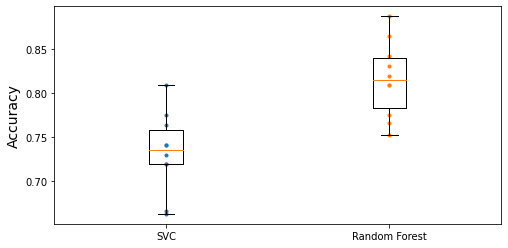

In [36]:
plt.figure(figsize=(8, 4))
plt.plot([1]*10, svc_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svc_scores, forest_scores], labels=("SVC", "Random Forest"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()

In [39]:
train["AgeBucket"] = train["Age"] // 15 * 15
train[["AgeBucket", "Survived"]].groupby(["AgeBucket"]).mean()


,Survived
AgeBucket,
0.0,0.576923
15.0,0.362745
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


In [40]:
train["RelativesOnBoard"] = train["SibSp"] + train["Parch"]
train[["RelativesOnBoard", "Survived"]].groupby(["RelativesOnBoard"]).mean()

,Survived
RelativesOnBoard,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


In [51]:
X_train = preprocess_pipeline.transform(train)

In [52]:
from sklearn.ensemble import RandomForestClassifier

forest_model = RandomForestClassifier(n_estimators=50, random_state=42)
forest_model.fit(X_train, y_train)
forest_scores = cross_val_score(forest_model, X_train, y_train, cv=10)
forest_scores.mean()

0.8159925093632958

In [83]:
final_predictions = forest_model.predict(X_test)
df = pd.DataFrame()
df["preds"] = final_predictions

In [84]:
submission = pd.read_csv("gender_submission.csv", usecols=["PassengerId"])
submission.head()

,PassengerId
0,892
1,893
2,894
3,895
4,896


In [85]:
submission["Survived"] = final_predictions

In [86]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,1


In [87]:
submission.to_csv("final_submission.csv")
submission.reset_index(drop=True, inplace=True)

In [88]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,1


In [90]:
submission.to_csv("my_final_submission.csv", index=False)